# Coupling heat transfer simulations

In this demo, we will perform a H transport simulation with coupled heat transfer on a hollow rectangle.


## 1. Problem definition

 <p align="center">
  <img src="https://user-images.githubusercontent.com/40028739/105063118-a293bb00-5a7b-11eb-9f55-30b627f4b173.jpg" width="40%">
</p>


- $D(T) = 4.1\times 10^{-7} \exp{(-0.39/k_B T)}$
- Trap:
    - Density: $n_1 = \times 10^{25} \text{ m}^{-3}$
    - Trapping rate: $k(T) = 3.8 \times 10^{-17} \exp{(-0.39/k_B T)} \text{ s}^{-1}$
    - Detrapping rate: $p(T) = 8.4\times 10^{12} \exp{(-1.2/k_B T)} \text{ s}^{-1}$


Boundary conditions:

- $c_\mathrm{m} = 10^{19} (1 + \cos(x)) \; \mathrm{m}^{-3} \text{  on } \Gamma_\mathrm{left}, \Gamma_\mathrm{top}, \Gamma_\mathrm{right}$
- $-D \nabla c_\mathrm{m} \cdot n = -K c_\mathrm{m}^2 \text{  on }\Gamma_\mathrm{right}$
with $K = 10^{-7} \exp{(-1/k_B T)} \; \mathrm{m}^4 \mathrm{s}^{-1}$
- $-D \nabla c_\mathrm{m} \cdot n = 0 \text{  else}$

The objective of this demo is to couple heat transfer simulations.

The following heat equation will be solved:

\begin{equation}
    \nabla( \lambda \nabla T) + Q = 0
\end{equation}
where $T$ is the temperature in $\text{K}$.

With:
- $\lambda = 3 + 0.1 T$ the thermal conductivity in $\text{W/m/K}$
- $Q=1+0.1 x$ the volumetric heat source in $\text{W/m}^3$.
- $-\lambda \nabla T \cdot n = 10+3\cos(x) + \sin(y) \text{  on }\Gamma_\mathrm{right}, \Gamma_\mathrm{bottom}$
- $-\lambda \nabla T \cdot n = -h (T - T_\mathrm{ext}) \text{  on }\Gamma_\mathrm{circle}$
with $h=100x$ the heat exchange coefficient in $\text{W/m}^2\text{/K}$  and $T_\mathrm{ext}=300 + 3y$ the external temperature in $\text{K}$
- $T = 350 + 20\cos{x}\sin{y} \text{  on }\Gamma_\mathrm{left}, \Gamma_\mathrm{top}$

## 2. Implementation
The first step is to create an empty parameters dictionnary

In [1]:
parameters = {}

### 2.1 Materials.
Since we want to couple the heat transfer simulation, the thermal conductivity needs to be provided.

In our example, the thermal conductivity is depending on the temperature.

Note: when solving the transient heat equation, two additionnal keys need to be provided. The keys `"heat_capacity"` and `"rho"` for the heat capacity in $\text{J/kg/K}$ and the density in $\text{kg/m}^3$

In [2]:
def thermal_cond(T):
    return 3 + 0.1*T

parameters["materials"] = [
    {
    "E_D": 0.39,
    "D_0": 4.1e-7,
    "thermal_cond": thermal_cond,
    "id": 1
    }
]

### 2.2 Meshing
The mesh will be created with FEniCS.

In [3]:
from fenics import Point, CompiledSubDomain, MeshFunction, plot
from mshr import Rectangle, Circle, generate_mesh
# creating a mesh with FEniCS
lx = ly = 10
cx = cy = lx / 2.0
radius = 2.5
res = 30
rectangle = Rectangle(Point(0, 0), Point(lx, ly))
hole = Circle(Point(cx, cy), radius)
mesh_fenics = generate_mesh(rectangle - hole, res)

# marking physical groups (volumes and surfaces)
volume_markers = MeshFunction("size_t", mesh_fenics, mesh_fenics.topology().dim())
volume_markers.set_all(1)

tol = 1e-14
left_surface = CompiledSubDomain('on_boundary && near(x[0], 0, tol)',
                                tol=tol)
right_surface = CompiledSubDomain('on_boundary && near(x[0], lx, tol)',
                                     tol=tol, lx=lx)
top_surface = CompiledSubDomain('on_boundary && near(x[1], ly, tol)',
                                     tol=tol, ly=ly)
bottom_surface = CompiledSubDomain('on_boundary && near(x[1], 0, tol)',
                                     tol=tol)
surface_markers = MeshFunction("size_t", mesh_fenics, mesh_fenics.topology().dim() - 1)
surface_markers.set_all(0)  # gamma_circle
left_surface.mark(surface_markers, 1)
top_surface.mark(surface_markers, 2)
right_surface.mark(surface_markers, 3)
bottom_surface.mark(surface_markers, 4)

# creating mesh with FESTIM
parameters["mesh_parameters"] = {
    "mesh": mesh_fenics,
    "meshfunction_cells": volume_markers,
    "meshfunction_facets": surface_markers,
}


### 2.3 Traps
`"k_0"` and `"E_k"` are the trapping rate pre-exponential factor in $\text{m}^{3} \text{s}^{-1}$ and activation energy in $\text{eV}$.

`"p_0"` and `"E_p"` are the detrapping rate pre-exponential factor in $\text{s}^{-1}$ and activation energy in $\text{eV}$.

`"materials"` is a list of the materials' ids where the trap is.

In [4]:
parameters["traps"] = [
    {
    "k_0": 3.8e-17,
    "E_k": 0.39,
    "p_0": 8.4e12,
    "E_p": 0.9,
    "density": 1e25,
    "materials": [1]
}
]

### 2.4 Temperature
The temperature field will be computed from solving the heat transfer equation.
Similarly to H transport problems, boundary conditions and source terms must be provided.

To solve a stationary problem, the key `"type"` needs to be set to `"solve_stationary"`.

In [5]:
import sympy as sp
from FESTIM import x, y

parameters["temperature"] = {
    "type": "solve_stationary",
    "boundary_conditions": [
        {
            "type": "dc",
            "surfaces": [1, 2],
            "value": 350 + 20*sp.cos(x)*sp.sin(y),
        },
        {
            "type": "convective_flux",
            "surfaces": [0],
            "h_coeff": 100*x,
            "T_ext": 300 + 3*y
        },
        {
            "type": "flux",
            "surfaces": [3, 4],
            "value": 10 + 3*sp.cos(x) + sp.sin(y),
        },
    ],
    "source_term": [
        {
            "value": 1 + 0.1*x,
            "volume": 1
        },
    ]
}

### 2.5 Boundary conditions

In [6]:
boundary_conditions = [
            {
                "surfaces": [1, 2, 3],
                "value": 1e19*(1 + sp.cos(x)),
                "type": "dc"
                
            },

            {
                "surfaces": [0],
                "type": "recomb",
                "Kr_0": 1e-7,
                "E_Kr": 1,
                "order": 2,
            }
    ]

parameters["boundary_conditions"] = boundary_conditions

### 2.6 Exports
The fields will be exported as XDMF files.

In [7]:
exports = {
    "xdmf": {
        "functions": ['1', 'solute', 'retention', 'T'],
        "labels": ['1', 'solute', 'retention', 'T'],
        "folder": 'outputs',
    },
}

parameters["exports"] = exports

### 2.7 Solving parameters
In order to solve the stationary problem, the key `"type"` has to be set to `"solve_stationary"`.

In [8]:
solving_parameters = {
    "type": "solve_stationary",

    "newton_solver": {
        "absolute_tolerance": 1e10,
        "relative_tolerance": 1e-9,
        "maximum_iterations": 50,
    },

}

parameters["solving_parameters"] = solving_parameters

### 2.8 Run the simulation

In [9]:
from FESTIM.generic_simulation import run
output = run(parameters)

Defining variational problem heat transfers
Solving stationary heat equation
Defining initial values
Defining variational problem
Defining boundary conditions
Solving steady state problem...


## 3. Post-processing 

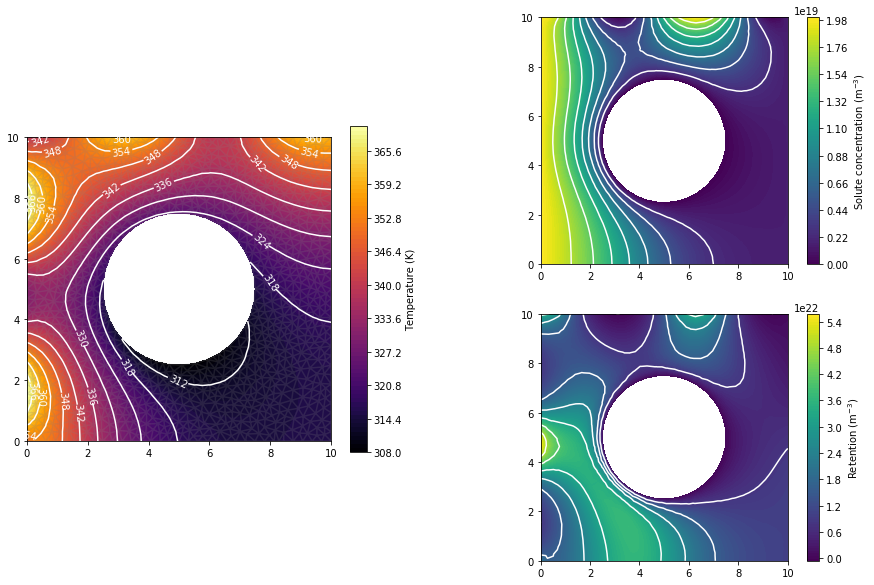

In [10]:
from fenics import XDMFFile, FunctionSpace, Function, plot, Mesh
import matplotlib.pyplot as plt


def load_field(mesh, fieldfile, field, element="CG", counter=-1):

    V = FunctionSpace(mesh, element, 1)
    u = Function(V)

    XDMFFile(fieldfile).read_checkpoint(u, field, counter)
    return u


# get the mesh from the output
mesh = output["mesh"]

# read the solutions
T = load_field(mesh, "outputs/T.xdmf", "T")
solute = load_field(mesh, "outputs/solute.xdmf", "solute", element="DG")
trap1 = load_field(mesh, "outputs/1.xdmf", "1")
retention = load_field(mesh, "outputs/retention.xdmf", "retention")

# plot
plt.figure(figsize=(15, 10))

# plot temperature
plt.subplot(1, 2, 1)
CF = plot(T, cmap="inferno", levels=100)
plot(mesh, alpha=0.2)
CS = plot(T, mode="contour", colors="white", levels=10)
CL = plt.clabel(CS, inline=True, fmt='%.f')
CB = plt.colorbar(CF, shrink=0.6, label="Temperature (K)")

# plot solute concentration
plt.subplot(2, 2, 2)
CF = plot(solute, levels=100)
CS = plot(solute, mode="contour", colors="white", levels=8)
CB = plt.colorbar(CF, label="Solute concentration (m$^{-3}$)")

# plot retention
plt.subplot(2, 2, 4)
CF = plot(retention, levels=100)
CS = plot(retention, mode="contour", colors="white", levels=8)
CB = plt.colorbar(CF, label="Retention (m$^{-3}$)")

### Plot profiles

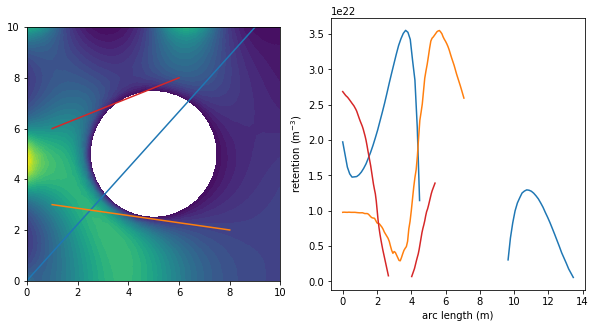

In [11]:
import numpy as np
def profile(function, start_point, end_point, nb):
    points_x = np.linspace(start_point[0], end_point[0], num=nb)
    points_y = np.linspace(start_point[1], end_point[1], num=nb)
    z, arc_length = [], []
    for i in range(len(points_x)):
        try:
            z.append(function(points_x[i], points_y[i]))
        except RuntimeError:
            z.append(float("nan"))
            
        arc_length.append(np.linalg.norm(np.array([points_x[i], points_y[i]]) - np.array(start_point)))

    return z, arc_length, points_x, points_y


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# plot the retention
plt.sca(axs[0])
plot(retention)

start_points = [(0, 0), (8, 2), (1, 6)]
end_points = [(9, 10), (1, 3), (6, 8)]
colours = ["tab:blue", "tab:orange", "tab:red"]
for start_point, end_point, colour in zip(start_points, end_points, colours):
    # compute the profile
    z, arc_length, points_x, points_y = profile(retention, start_point, end_point, nb=100)
    # plot
    plt.sca(axs[0])
    plt.plot(points_x, points_y, color=colour)
    plt.sca(axs[1])
    plt.plot(arc_length, z, color=colour)
axs[1].set_xlabel("arc length (m)")
axs[1].set_ylabel("retention (m$^{-3}$)")
plt.show()

### Compute custom quantities

Further computations can be performed with these fields.

For instance, the diffusion coefficient can be retrieved, but also the **trapping** and **detrapping rates**.

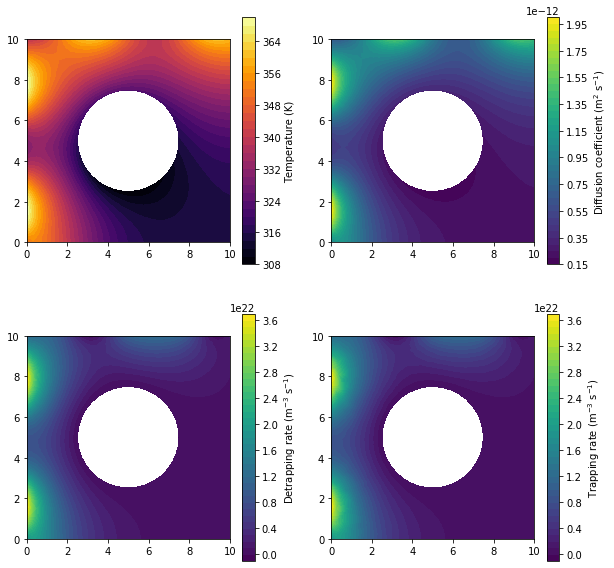

In [12]:
from fenics import exp, project
from FESTIM import k_B

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# plot temperature
plt.sca(ax1)
CF = plot(T, cmap="inferno")
CB = plt.colorbar(CF, label="Temperature (K)")

# computing the diffusion coefficient in m2 s-1
D = 4.1e-7*exp(-0.39/k_B/T)
plt.sca(ax2)
CF = plot(D)
CB = plt.colorbar(CF, label="Diffusion coefficient (m$^2$ s$^{-1}$)")

# computing the detrapping rate in m-3 s-1
p = 8.4e12*exp(-0.9/k_B/T)
detrapping_rate = p*trap1
plt.sca(ax3)
CF = plot(detrapping_rate)
CB = plt.colorbar(CF, label="Detrapping rate (m$^{-3}$ s$^{-1}$)")

# computing the trapping rate in m-3 s-1
k = 3.8e-17*exp(-0.39/k_B/T)
density = 1e25
trapping_rate = project(k*solute*(density - trap1), FunctionSpace(mesh, "DG", 1))
plt.sca(ax4)
CF = plot(trapping_rate)
CB = plt.colorbar(CF, label="Trapping rate (m$^{-3}$ s$^{-1}$)")

plt.show()